In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append('/exploiting_model_multiplicity')
sys.path.append('/exploiting_model_multiplicity/my_utilities')
from config_reader import read_config
from pathlib import Path
from torch import cuda, backends, no_grad
from get_disagreement import calc_disagreemnt

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Reorganasie folders 

B. Predictions Analysis
 - Disagreement per experiment 
 - New plot
 - Feature importance 
 - ?
C. Group Analysis 
D. Mitigation

### Input data

In [3]:
batches = "Batches_bank_marketing.yaml"
lr = "Lr_bank_marketing.yaml"
rs = "Random_seed_bank_marketing.yaml"

# TODO ONCE reade config, form path, run rediction and form other datasets for analysis

In [4]:
config_batches = read_config(batches)
batches_expmt = config_batches.get("project")
config_lr = read_config(lr)
lr_expmt = config_lr.get("project")
config_rs = read_config(rs)
rs_expmt = config_rs.get("project")

dataset_name = config_batches.get("parameters").get("dataset").get("value")

In [5]:
# making predictions 
def predict(config_file_name):
    config = read_config(config_file_name)
    experiment_name = config.get("project")
    dataset_name = config.get("parameters").get("dataset").get("value")
    my_file = Path(f"/exploiting_model_multiplicity/experiment_results/{dataset_name}/{experiment_name}/full.csv")
    if my_file.is_file():
        print(f"Predictions for {experiment_name} are in place")
    else:
        print(f"Run predictions for {experiment_name}")
        %run /exploiting_model_multiplicity/get_predictions.py --config {config_file_name}

In [6]:
predict(batches)
predict(lr)
predict(rs)

Predictions for Batches_1024_bank are in place
Predictions for LearninRate_bank are in place
Predictions for Random_seed_bank are in place


## Models metadata statistics

In [7]:
# all models that have been saved during the training (after each epoch)
bs_path = f"/exploiting_model_multiplicity/models/{dataset_name}/{batches_expmt}/metadata/all_models.csv"
lr_path = f"/exploiting_model_multiplicity/models/{dataset_name}/{lr_expmt}/metadata/all_models.csv"
rs_path = f"/exploiting_model_multiplicity/models/{dataset_name}/{rs_expmt}/metadata/all_models.csv"

pred_bs = pd.read_csv(bs_path)
pred_lr = pd.read_csv(lr_path)
pred_rs = pd.read_csv(rs_path)

# filter the dataframe and getting best model from each training 
pred_bs["Experiment"] = pred_bs['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_lr["Experiment"] = pred_lr['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_rs["Experiment"] = pred_rs['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_lr_new = pred_lr[["Experiment", "eval_acc", "lr"]]
pred_bs_new = pred_bs[["Experiment", "eval_acc", "batch_size"]]
pred_rs_new = pred_rs[["Experiment", "eval_acc", "seed"]]
# getting only top models from each run
idx_lr = pred_lr_new.groupby('Experiment')['eval_acc'].idxmax()
idx_bs = pred_bs_new.groupby('Experiment')['eval_acc'].idxmax()
idx_rs = pred_rs_new.groupby('Experiment')['eval_acc'].idxmax()
best_samples_lr = pred_lr_new.loc[idx_lr].reset_index(drop=True)
best_samples_bs = pred_bs_new.loc[idx_bs].reset_index(drop=True)
best_samples_rs = pred_rs_new.loc[idx_rs].reset_index(drop=True)

# combining the metadata from 3 experiments
best_samples_lr["Source"] = 'Batch'
best_samples_bs["Source"] = 'LR'
best_samples_rs["Source"] = 'Random seed'

combined_df = pd.concat([best_samples_lr, best_samples_bs, best_samples_rs])

In [8]:
# filtered 1% margin of Accuracy
bs_path_filt = f"/exploiting_model_multiplicity/models/{dataset_name}/{batches_expmt}/metadata/all_models_filtered.csv"
lr_path_filt = f"/exploiting_model_multiplicity/models/{dataset_name}/{lr_expmt}/metadata/all_models_filtered.csv"
rs_path_filt = f"/exploiting_model_multiplicity/models/{dataset_name}/{rs_expmt}/metadata/all_models_filtered.csv"

pred_bs_filt = pd.read_csv(bs_path_filt)
pred_lr_filt = pd.read_csv(lr_path_filt)
pred_rs_filt = pd.read_csv(rs_path_filt)
pred_bs_filt["Experiment"] = pred_bs_filt['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_lr_filt["Experiment"] = pred_lr_filt['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_rs_filt["Experiment"] = pred_rs_filt['Unnamed: 0'].str.extract(r'(\w+)-(\d+)').apply(lambda x: ''.join(x), axis=1)
pred_bs_filt = pred_bs_filt[["Experiment", "eval_acc", "batch_size"]]
pred_lr_filt = pred_lr_filt[["Experiment", "eval_acc", "lr"]]
pred_rs_filt = pred_rs_filt[["Experiment", "eval_acc", "seed"]]

pred_bs_filt["Source"] = 'Batch'
pred_lr_filt["Source"] = 'LR'
pred_rs_filt["Source"] = 'Random seed'

combined_df_filt = pd.concat([pred_bs_filt, pred_lr_filt, pred_rs_filt])

### Evaluation accuracy distribution plot

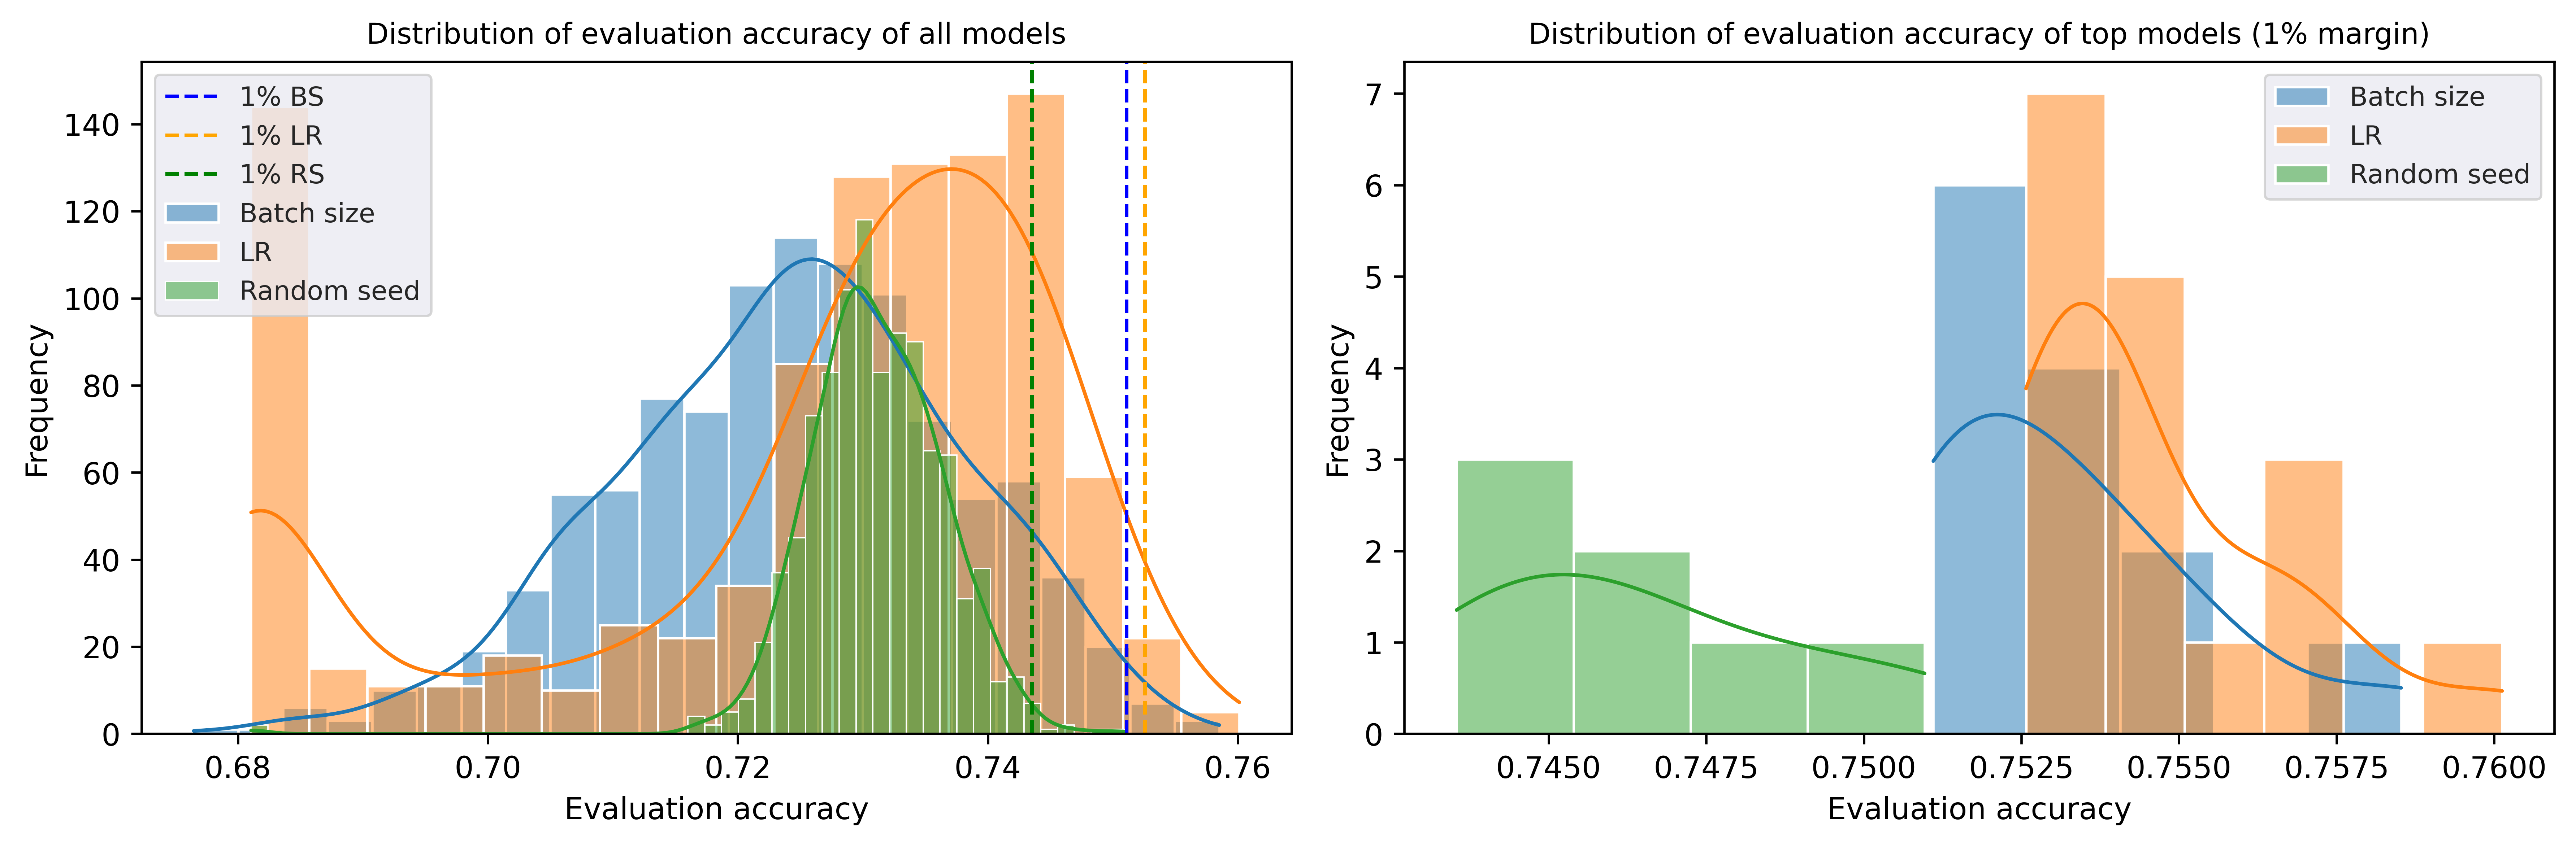

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False, dpi=600)
sns.set()
sns.set_context("paper")

sns.histplot(data=best_samples_bs, x='eval_acc', label='Batch size', kde=True, ax=axes[0])
sns.histplot(data=best_samples_lr, x='eval_acc', label='LR', kde=True, ax=axes[0])
sns.histplot(data=best_samples_rs, x='eval_acc', label='Random seed', kde=True, ax=axes[0])
axes[0].set_title('Distribution of evaluation accuracy of all models')
axes[0].set_xlabel('Evaluation accuracy')
axes[0].set_ylabel('Frequency')
axes[0].legend()

sns.histplot(data=pred_bs_filt, x='eval_acc', label='Batch size', kde=True, ax=axes[1])
sns.histplot(data=pred_lr_filt, x='eval_acc', label='LR', kde=True, ax=axes[1])
sns.histplot(data=pred_rs_filt, x='eval_acc', label='Random seed', kde=True, ax=axes[1])
axes[1].set_title('Distribution of evaluation accuracy of top models (1% margin)')
axes[1].set_xlabel('Evaluation accuracy')
axes[1].set_ylabel('Frequency')
axes[1].legend()

min_val_bs = pred_bs_filt['eval_acc'].min()
min_val_lr = pred_lr_filt['eval_acc'].min()
min_val_rs = pred_rs_filt['eval_acc'].min()

axes[0].axvline(x=min_val_bs, color='blue', linestyle='--', label='1% BS')
axes[0].axvline(x=min_val_lr, color='orange', linestyle='--', label='1% LR')
axes[0].axvline(x=min_val_rs, color='green', linestyle='--', label='1% RS')

axes[0].legend() 
plt.tight_layout()
plt.show()

### Descriptive statistics

In [10]:
def extract_stats(df):
    desc = df['eval_acc'].describe()
    return pd.Series({
        'num_of_models': desc['count'],
        'min.Acc': desc['min'],
        'max.Acc': desc['max'],
        'std.Acc': desc['std']
    })

In [11]:
combined_stats = pd.DataFrame({
    'Batche_size': extract_stats(best_samples_bs),
    'LR': extract_stats(best_samples_lr),
    'Random_seed': extract_stats(best_samples_rs),

})
combined_stats.round(3)

LR  Batche_size  Random_seed
num_of_models  1000.000     1022.000     1000.000
min.Acc           0.681        0.676        0.681
max.Acc           0.760        0.759        0.751
std.Acc           0.022        0.014        0.006

In [12]:
combined_stats = pd.DataFrame({
    'Batche_size': extract_stats(pred_bs_filt),
    'LR': extract_stats(pred_lr_filt),
    'Random_seed': extract_stats(pred_rs_filt),

})
combined_stats.round(3)

LR  Batche_size  Random_seed
num_of_models  17.000       13.000        7.000
min.Acc         0.753        0.751        0.744
max.Acc         0.760        0.759        0.751
std.Acc         0.002        0.002        0.003

### Hyperparameters statistics over all models

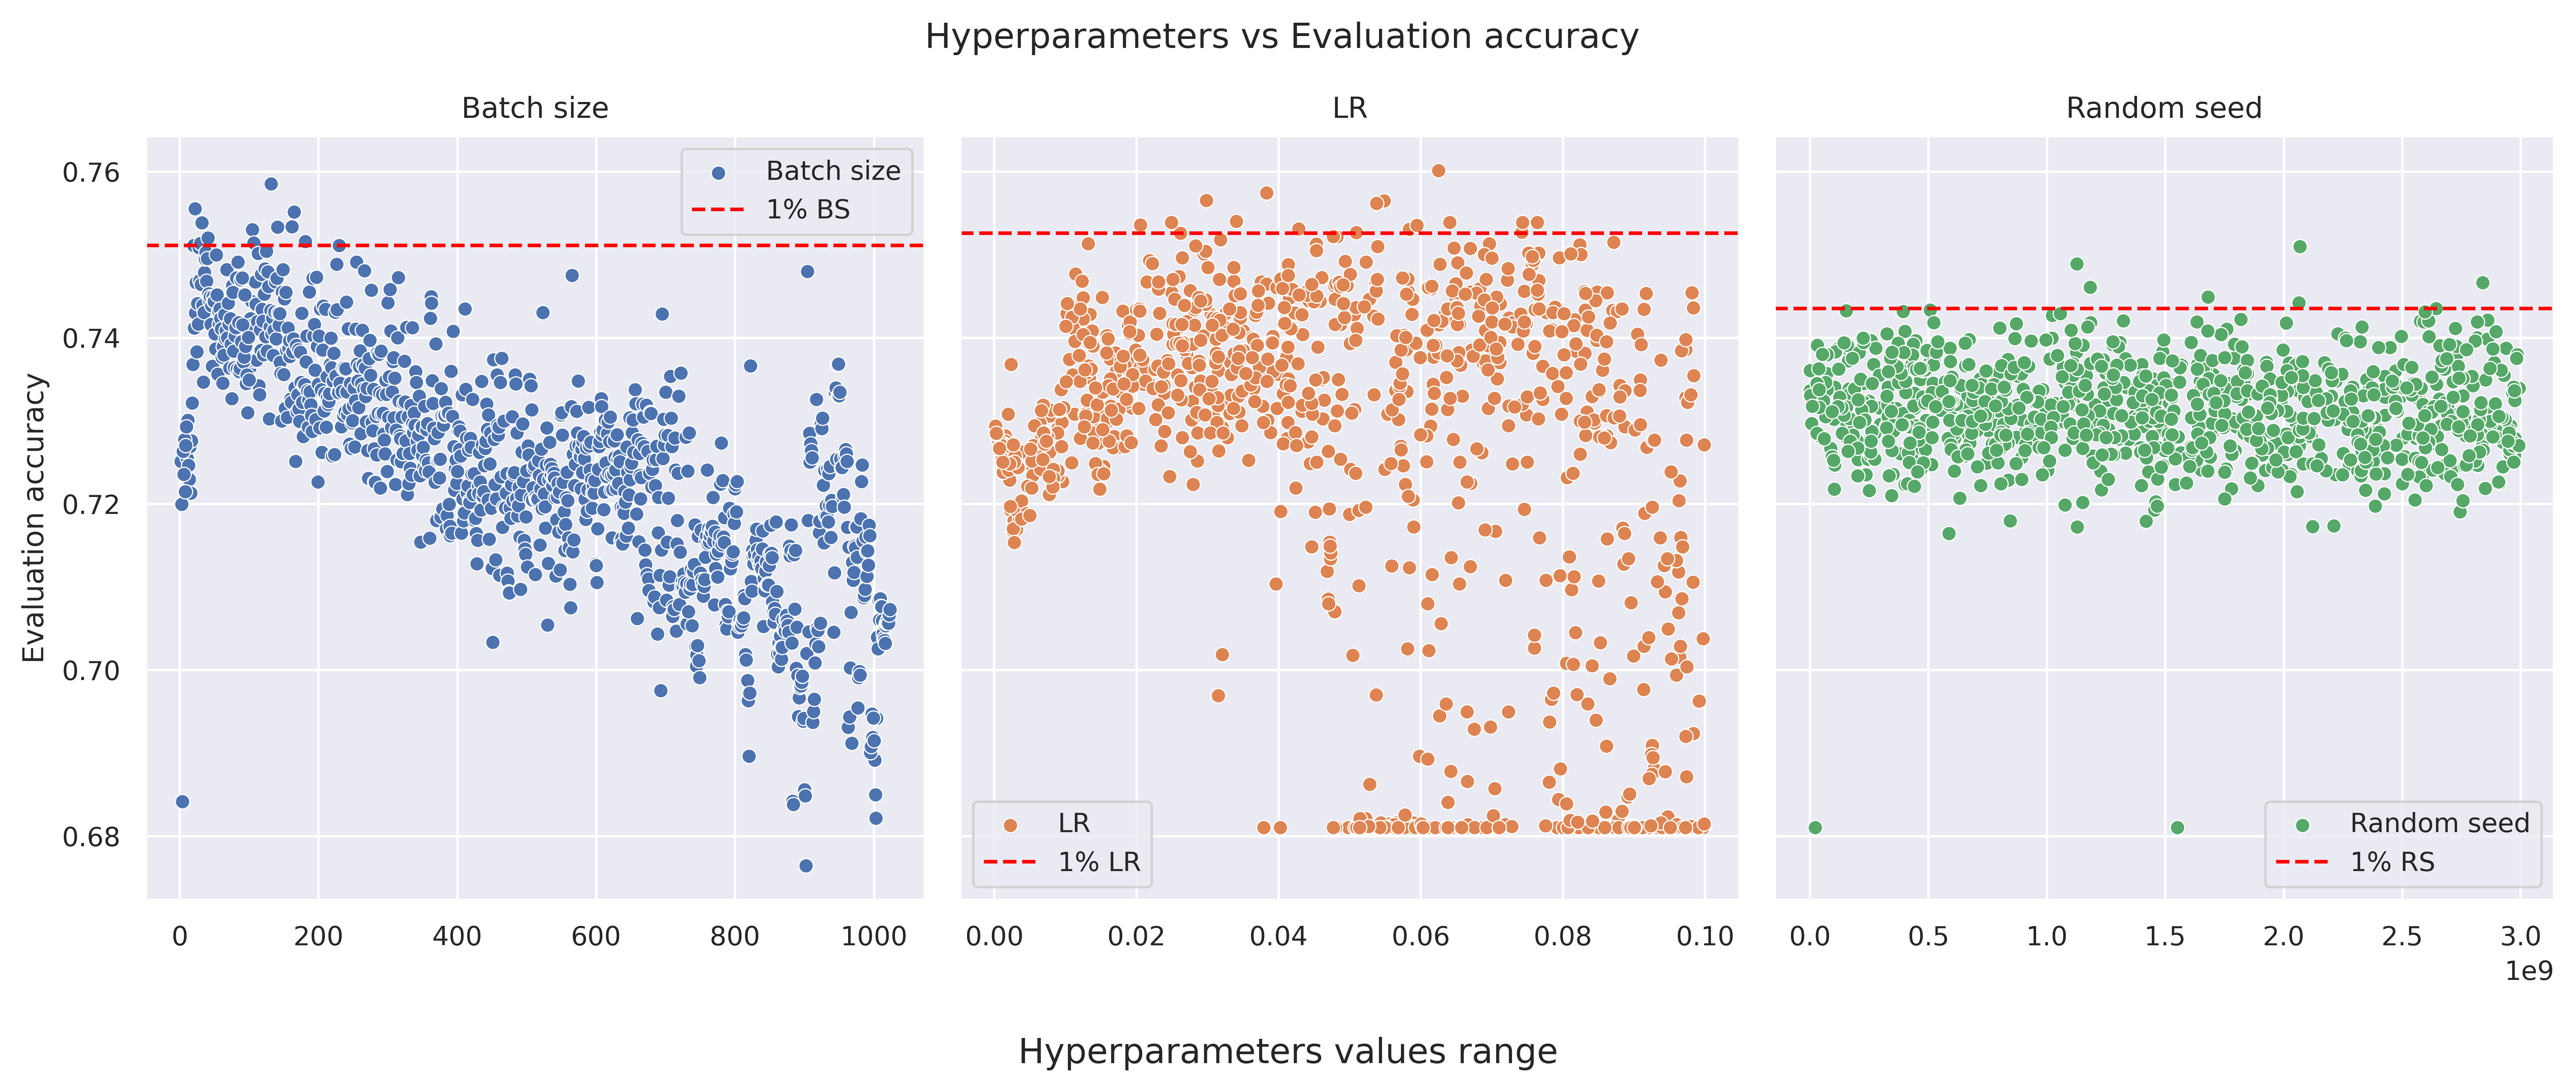

In [13]:
colors = sns.color_palette("deep", 3)

data_frames = [best_samples_bs, best_samples_lr, best_samples_rs]
labels = ['Batch size', 'LR', 'Random seed']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharex=False, sharey=True, dpi=600)

sns.set()
sns.set_context("paper")
fig.suptitle('Hyperparameters vs Evaluation accuracy ')
fig.supxlabel('Hyperparameters values range')
for i, (data, label, color) in enumerate(zip(data_frames, labels, colors)):
    sns.scatterplot(data=data, x=data.iloc[:,2].values, y= data["eval_acc"], label=label, ax=axes[i], color=color)
    axes[i].set_title(f'{label}')
    axes[i].set_ylabel('Evaluation accuracy')
    axes[i].legend()

axes[0].axhline(y=min_val_bs, color='red', linestyle='--', label='1% BS')
axes[1].axhline(y=min_val_lr, color='red', linestyle='--', label='1% LR')
axes[2].axhline(y=min_val_rs, color='red', linestyle='--', label='1% RS')

axes[0].legend() 
axes[1].legend() 
axes[2].legend(loc='lower right') 
plt.tight_layout()
plt.show()

In [14]:
pred_lr_filt.head()

Experiment  eval_acc        lr Source
0    Expr944  0.752664  0.050953     LR
1    Expr916  0.753551  0.059454     LR
2    Expr862  0.756191  0.053792     LR
3    Expr837  0.754012  0.034080     LR
4    Expr768  0.753868  0.064111     LR

In [15]:
pred_bs_filt.head()

Experiment  eval_acc  batch_size Source
0    Expr229  0.751129         230  Batch
1    Expr180  0.751570         181  Batch
2    Expr164  0.755166         165  Batch
3    Expr161  0.753386         162  Batch
4    Expr140  0.753324         141  Batch

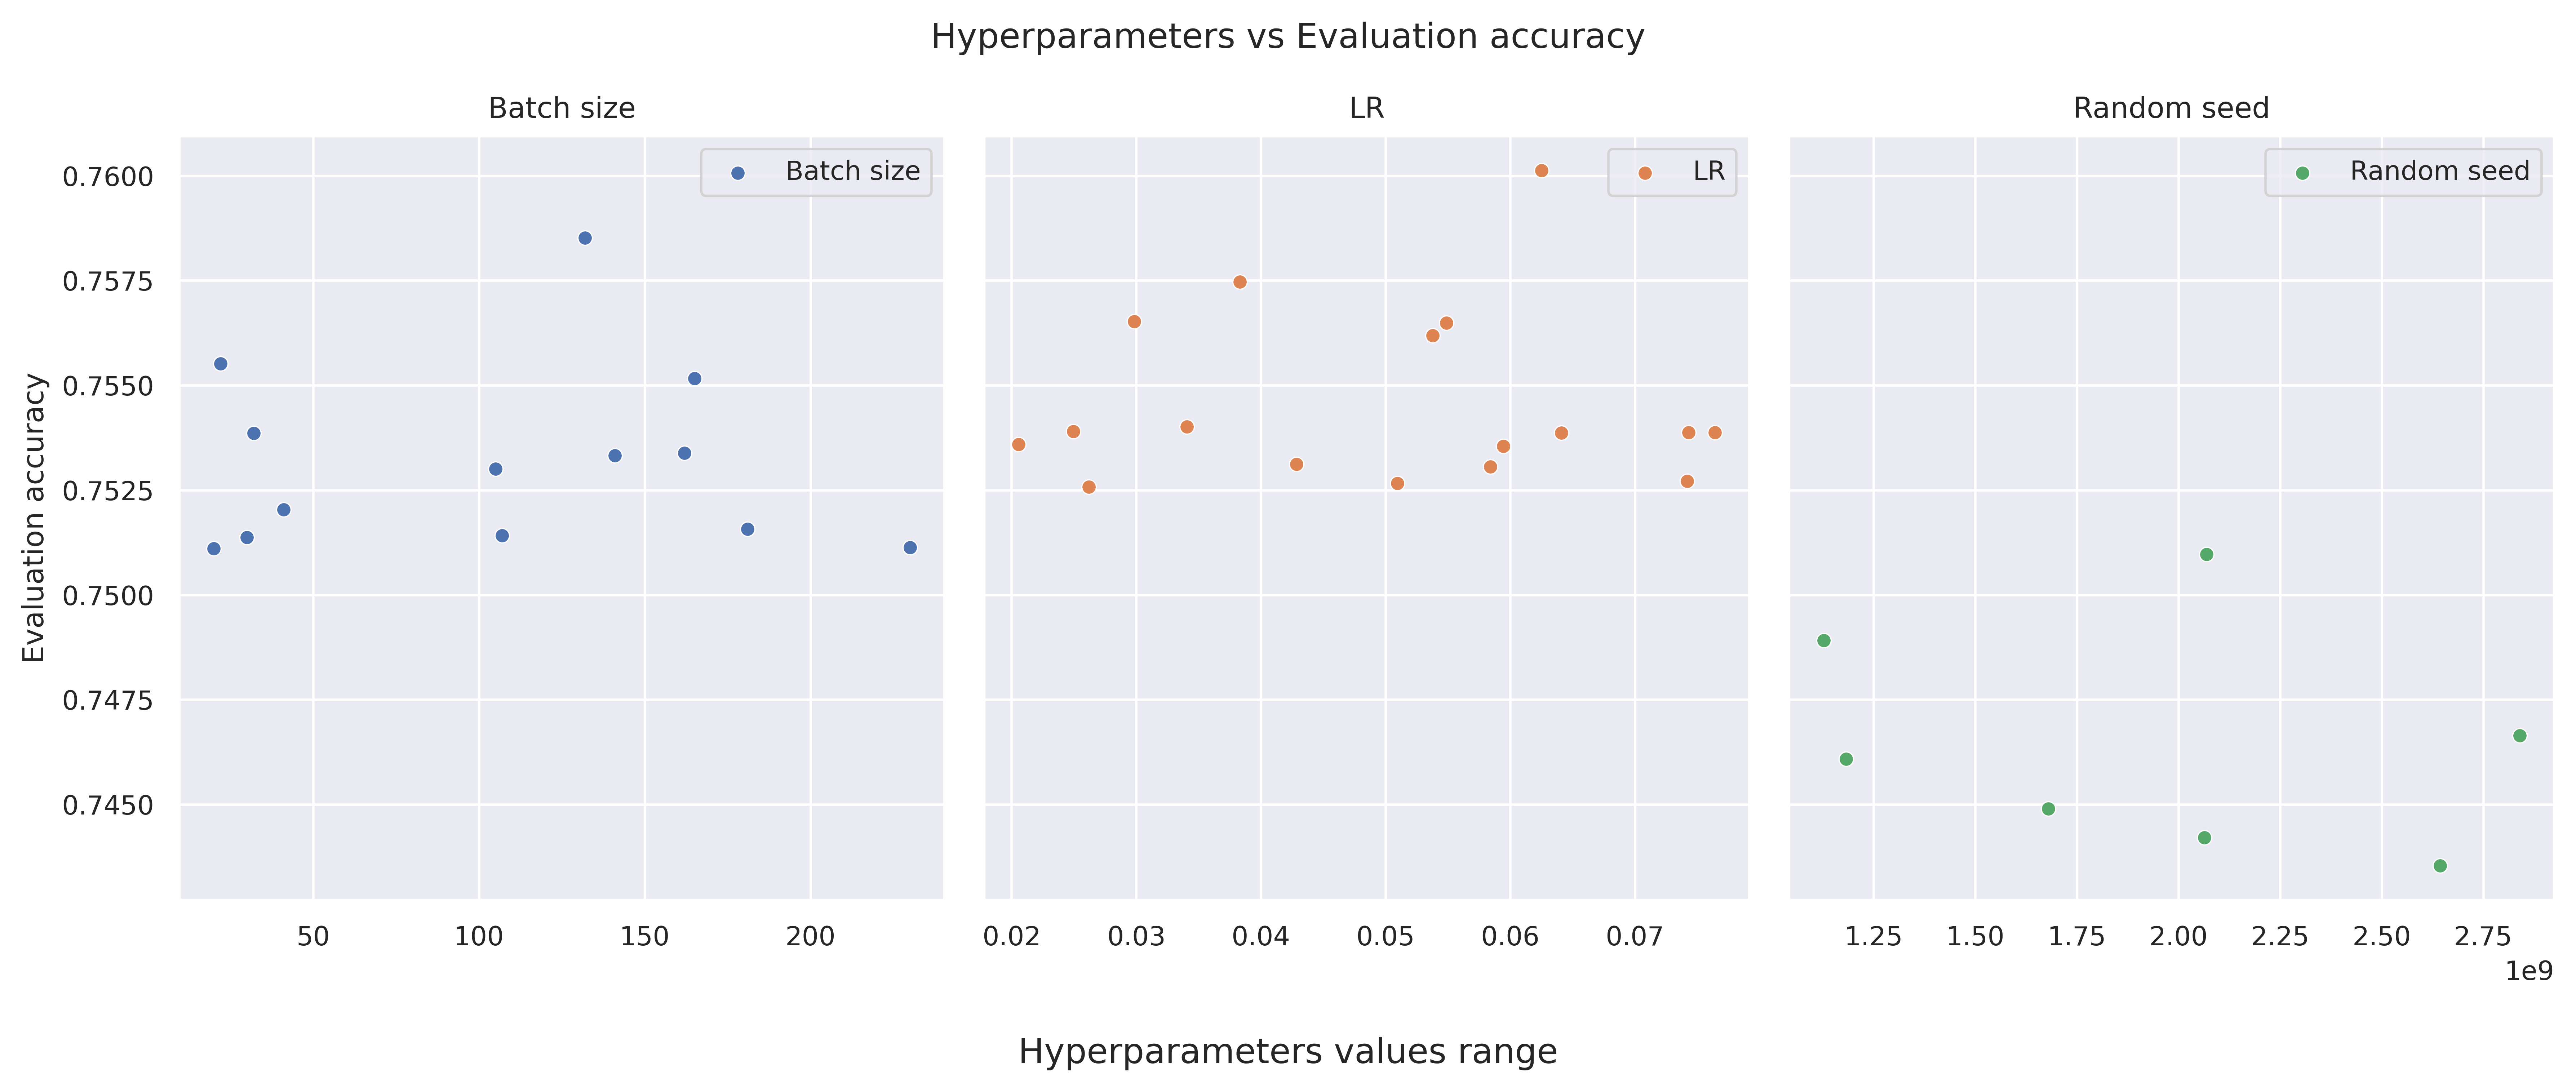

In [16]:
colors = sns.color_palette("deep", 3)

data_frames = [pred_bs_filt, pred_lr_filt, pred_rs_filt]
labels = ['Batch size', 'LR', 'Random seed']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharex=False, sharey=True, dpi=600)

sns.set()
sns.set_context("paper")
fig.suptitle('Hyperparameters vs Evaluation accuracy')
fig.supxlabel('Hyperparameters values range')
for i, (data, label, color) in enumerate(zip(data_frames, labels, colors)):
    sns.scatterplot(data=data, x=data.iloc[:,2].values, y= data["eval_acc"], label=label, ax=axes[i], color=color)
    axes[i].set_title(f'{label}')
    axes[i].set_ylabel('Evaluation accuracy')
    axes[i].legend()
plt.tight_layout()
plt.show()

### Hyperparameters statistics over TOP models

## Exploration of predictive multiplicity

1. General
    * New plot
    * Disagreement
    * Feature importance 
    * ? Distribution of inbalanced predictions
2. Group Analysis

#### Cumulattive conflicting predictions

In [17]:
def convert_to_binary(value):
    return 1 if value >= 0.5 else 0

In [18]:
def count_conflicts(df, num_cols):
    conflicts = 0
    for _, row in df.iloc[:, :num_cols].iterrows():
        if len(set(row)) > 1:  # If there are different values in the row slice
            conflicts += 1
    return conflicts

In [19]:
def calc_conflicts_per_model(config_file_name):
    config = read_config(config_file_name)
    experiment_name = config.get("project")
    dataset_name = config.get("parameters").get("dataset").get("value")
    ploject_data = {
    "num_columns": [],
    "conflicting_predictions": []
    }
    path = Path(f"/exploiting_model_multiplicity/experiment_results/{dataset_name}/{experiment_name}/full.csv")
    df = pd.read_csv(path, index_col="index")
    df.drop(columns="Unnamed: 0", inplace=True)
    df = df.applymap(convert_to_binary)
    for i in range(2, len(df.columns) + 1):
        ploject_data["num_columns"].append(i)
        ploject_data["conflicting_predictions"].append(count_conflicts(df, i))
    plot_df = pd.DataFrame(ploject_data)
    plot_df["conflicting_predictions"] = plot_df["conflicting_predictions"]/len(df)
    return plot_df

In [20]:
plot_data = {}
plot_data[batches] = calc_conflicts_per_model(batches)
plot_data[lr] = calc_conflicts_per_model(lr)
plot_data[rs] = calc_conflicts_per_model(rs)

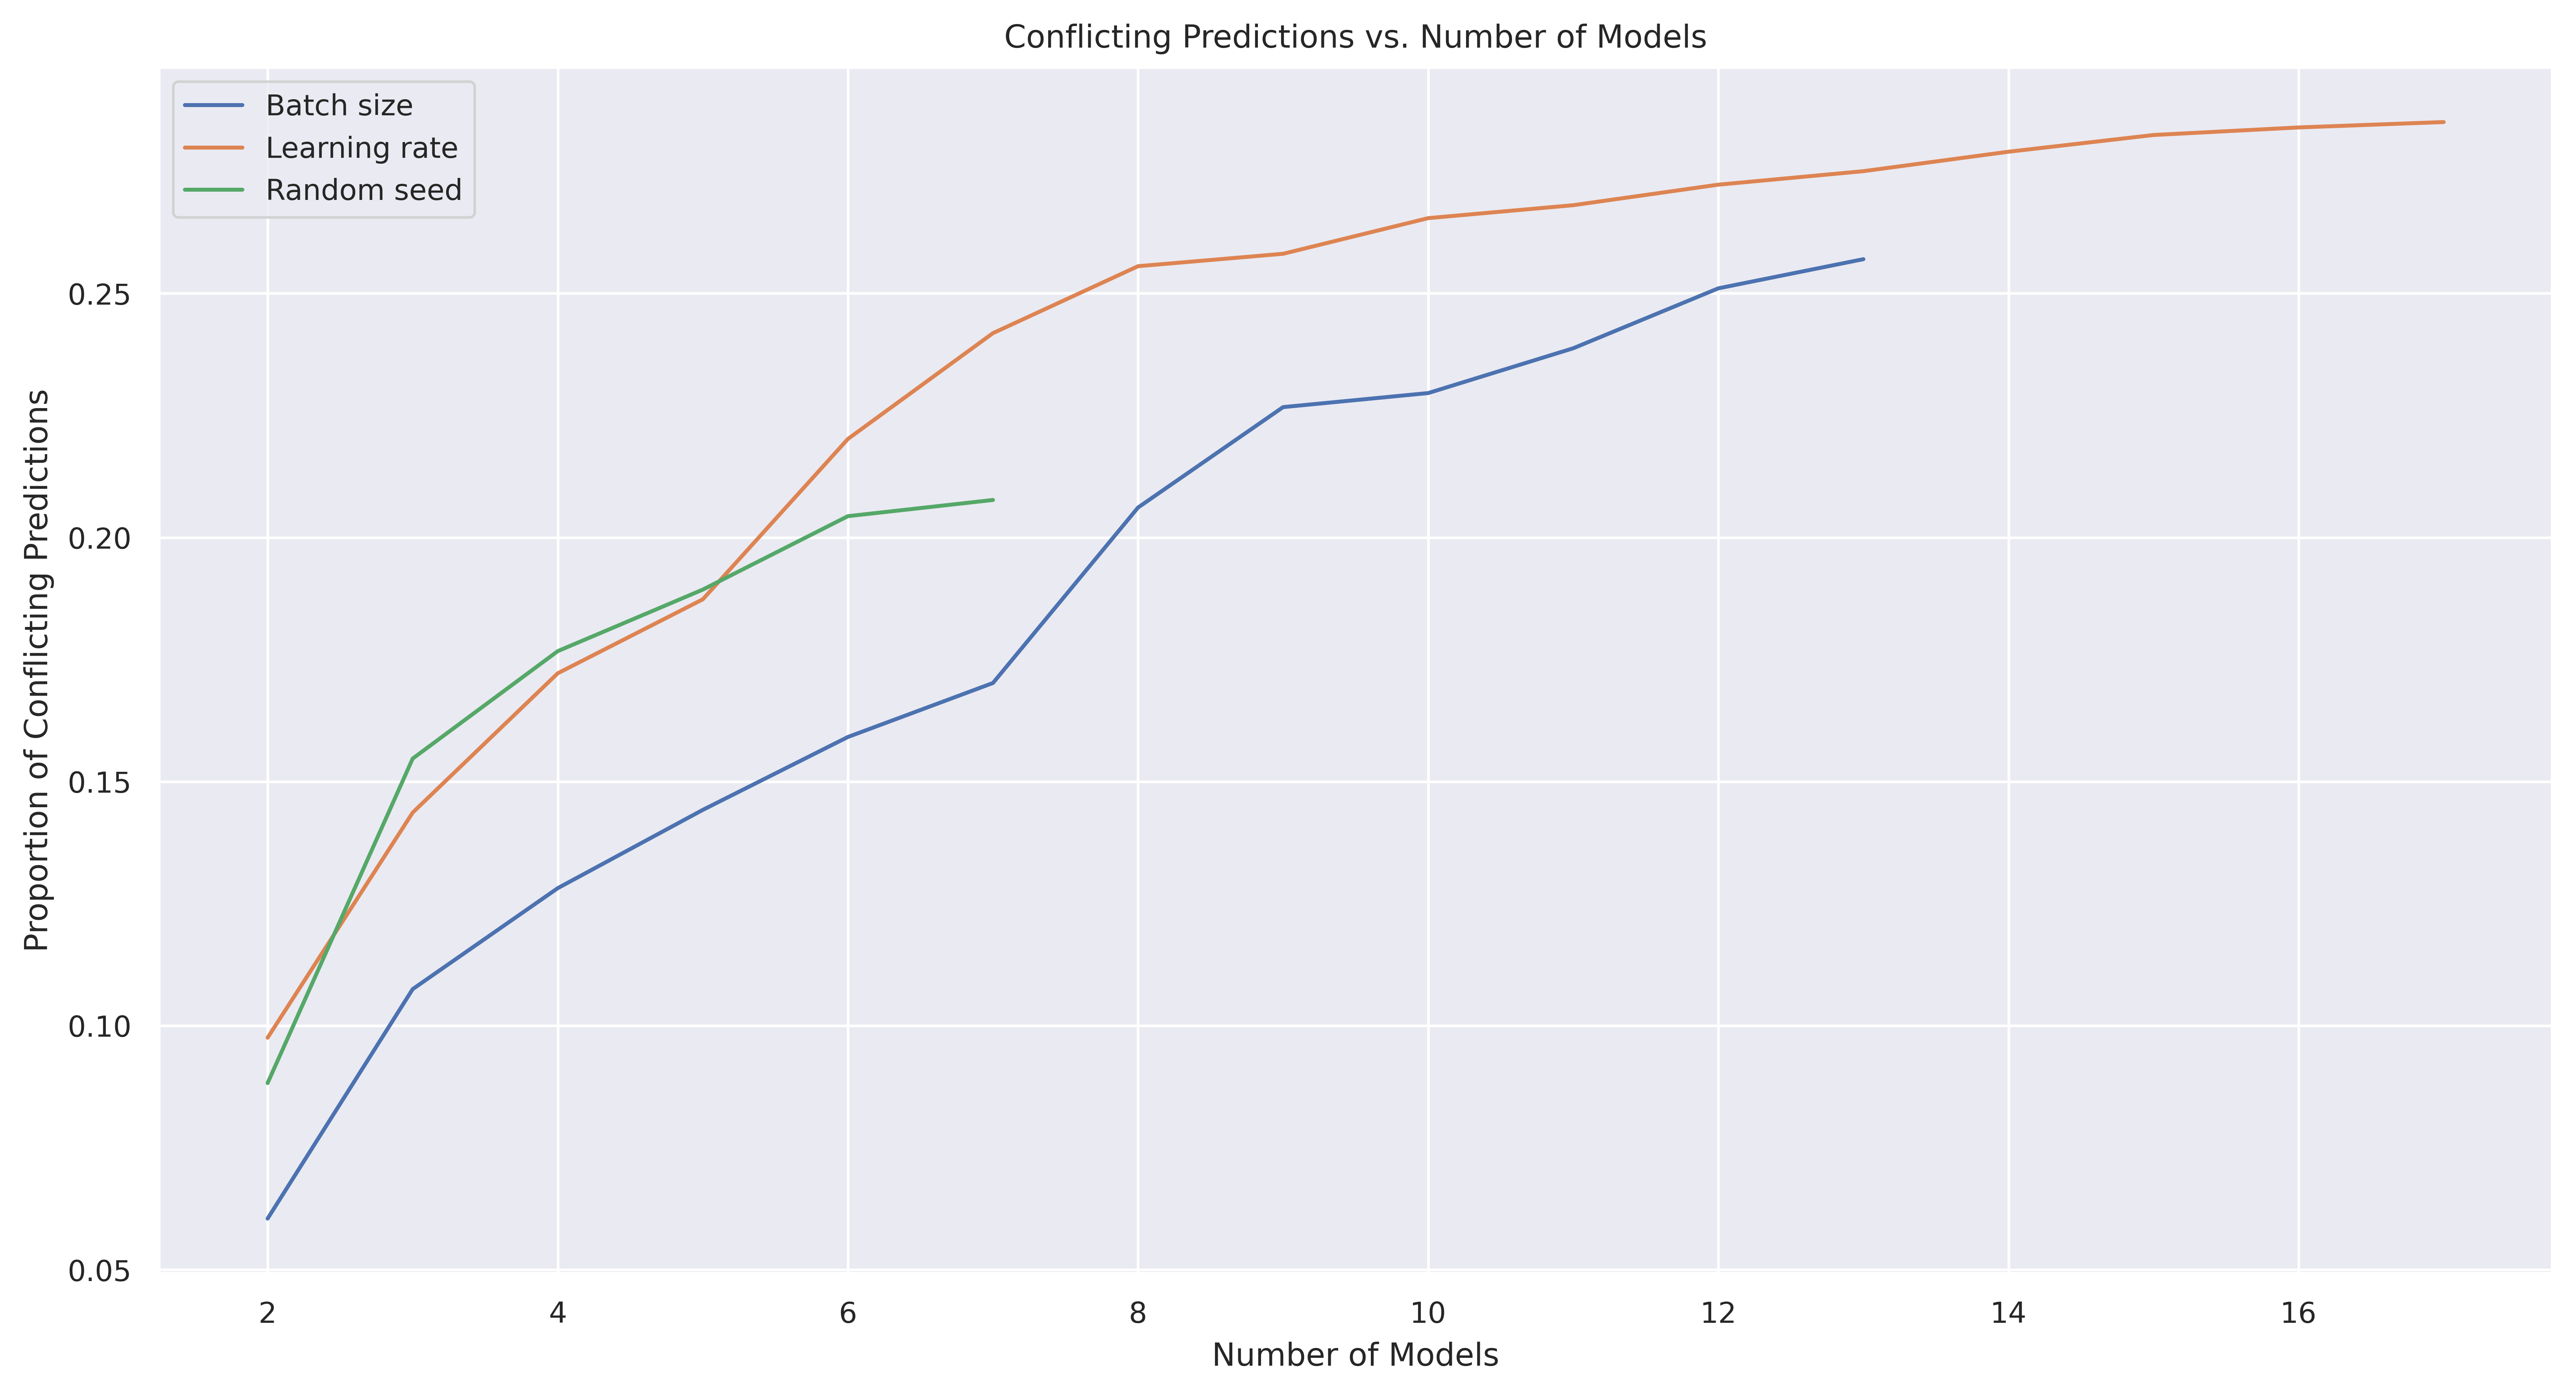

In [21]:
colors = sns.color_palette("deep", 3)
labels = ["Batch size", "Learning rate", "Random seed"]
plt.figure(figsize=(11, 6), dpi=600)

for key, color, label in zip(plot_data.keys(), colors, labels):
    sns.lineplot(data=plot_data[key], x='num_columns', y='conflicting_predictions', label=label, color=color)
    
plt.xlabel('Number of Models')
plt.ylabel('Proportion of Conflicting Predictions')

plt.title('Conflicting Predictions vs. Number of Models')
plt.tight_layout()
plt.legend()
plt.show()

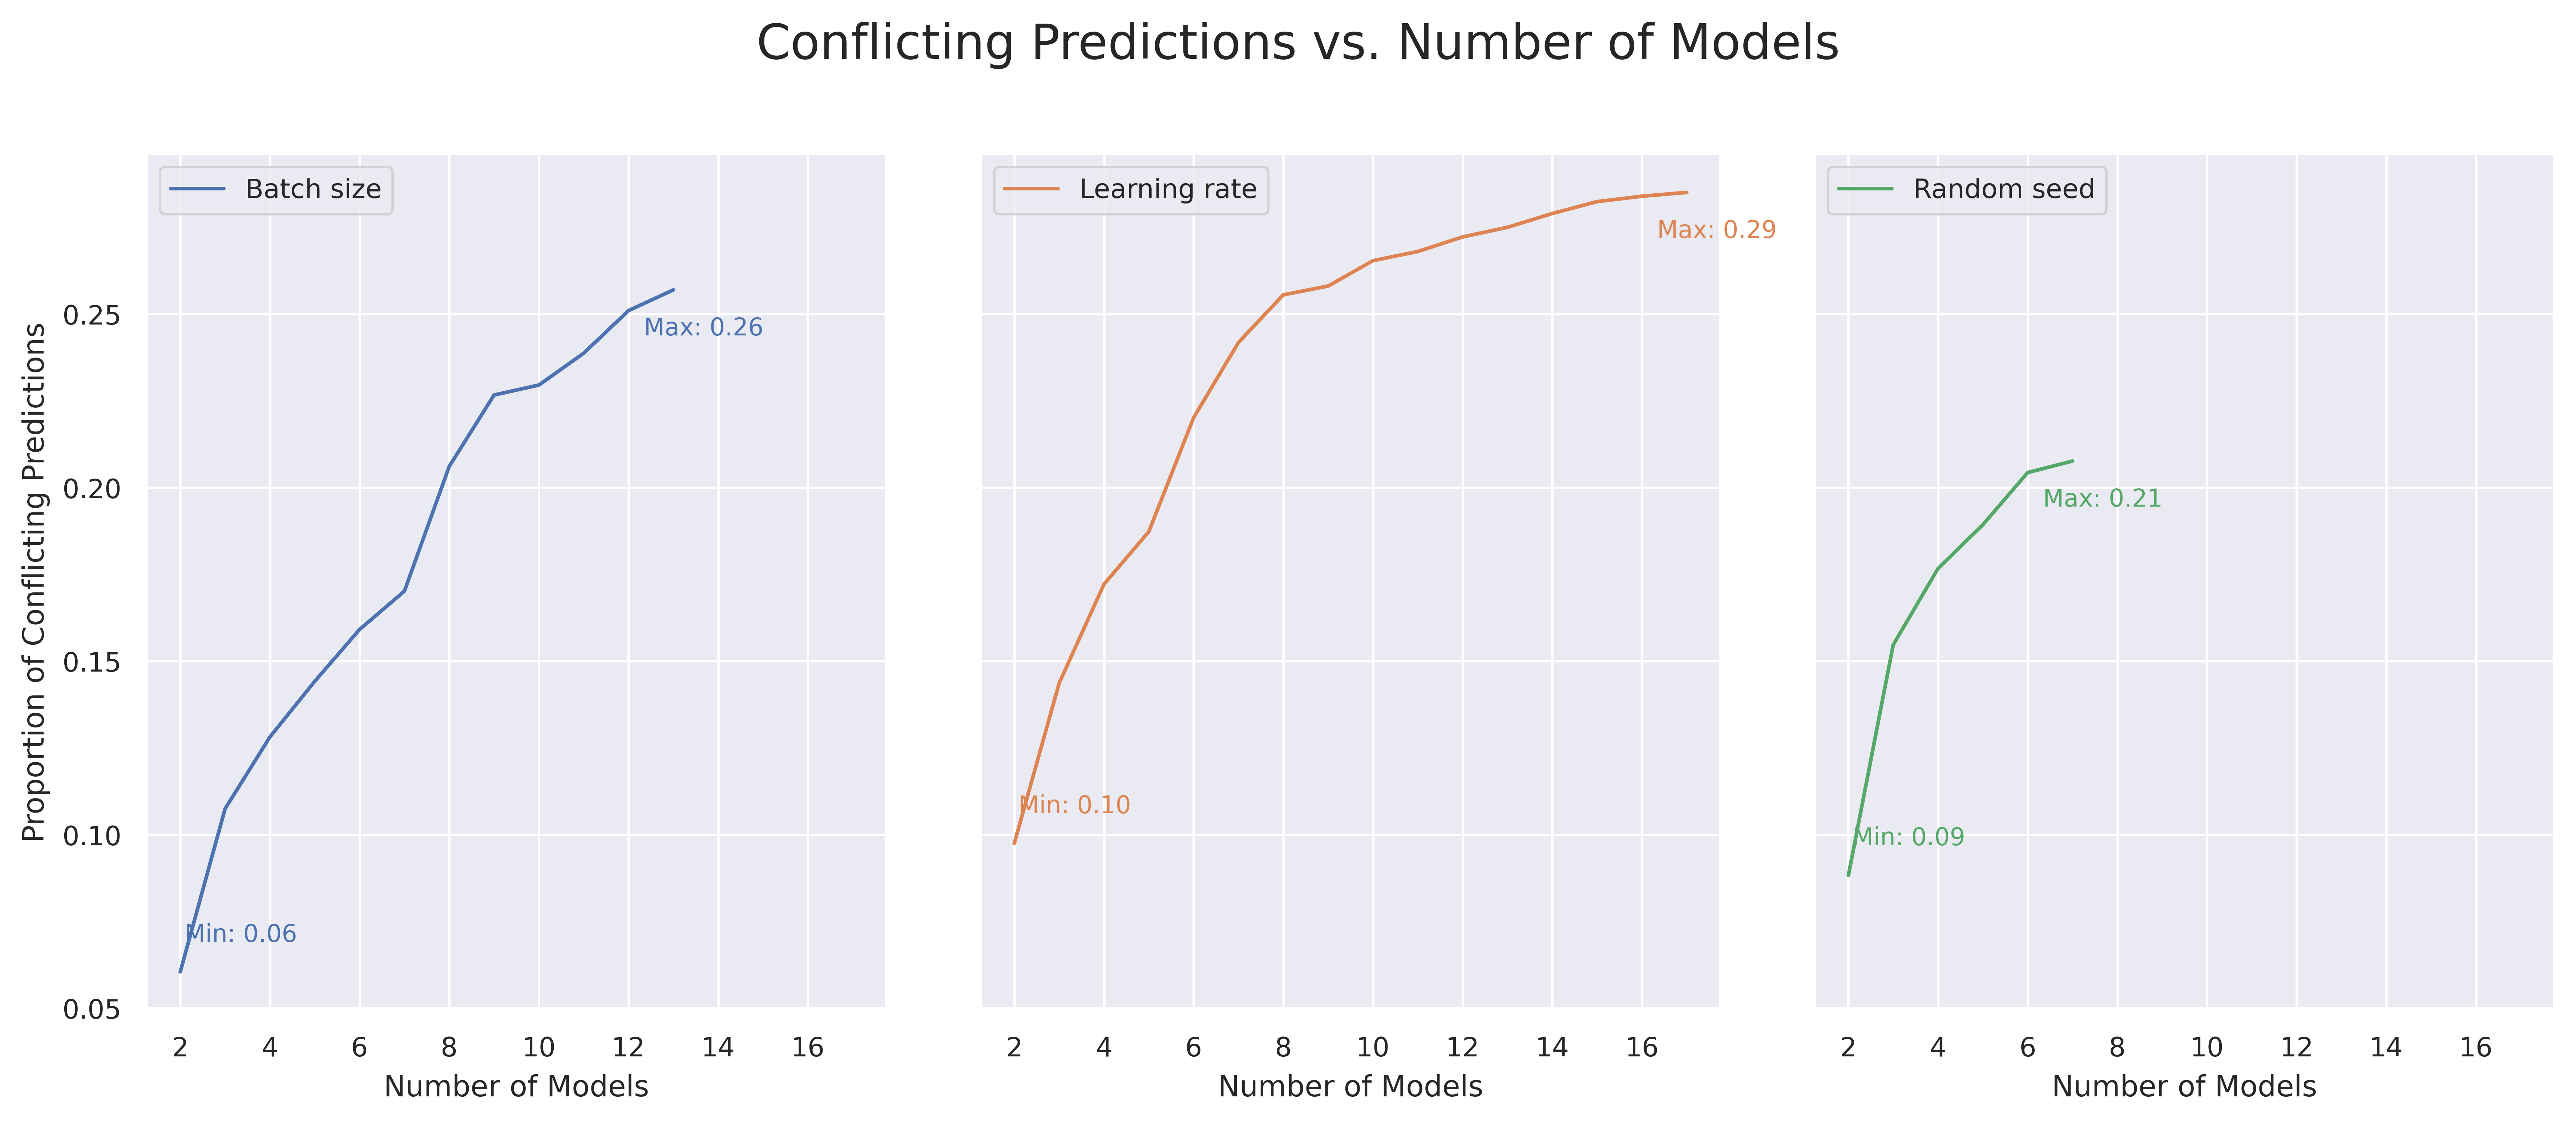

In [22]:
labels = ["Batch size", "Learning rate", "Random seed"]
colors = sns.color_palette("deep", 3)

fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=600, sharey=True, sharex=True)
fig.suptitle('Conflicting Predictions vs. Number of Models', fontsize=16, y=1.02)

for i, (key, label) in enumerate(zip(plot_data.keys(), labels)):
    sns.lineplot(data=plot_data[key], x='num_columns', y='conflicting_predictions', color=colors[i], ax=ax[i],label=label)
    
    ax[i].set_xlabel('Number of Models')
    ax[i].set_ylabel('Proportion of Conflicting Predictions')
    
    min_val = plot_data[key]['conflicting_predictions'].min()
    max_val = plot_data[key]['conflicting_predictions'].max()
    min_x = plot_data[key][plot_data[key]['conflicting_predictions'] == min_val]['num_columns'].iloc[0]
    max_x = plot_data[key][plot_data[key]['conflicting_predictions'] == max_val]['num_columns'].iloc[0]

    ax[i].annotate(f'Min: {min_val:.2f}', (min_x, min_val), textcoords="offset points", xytext=(20,10), ha='center', fontsize=8, color=colors[i])
    ax[i].annotate(f'Max: {max_val:.2f}', (max_x, max_val), textcoords="offset points", xytext=(10,-15), ha='center', fontsize=8, color=colors[i])
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

### Disagreement distribution

In [23]:
disagreement_bs = calc_disagreemnt(batches_expmt,
                               dataset_name,100)
disagreement_lr = calc_disagreemnt(lr_expmt,
                               dataset_name,100)
disagreement_rs = calc_disagreemnt(rs_expmt,
                               dataset_name,100)

data shaper (9043, 42)
data shaper (9043, 42)
data shaper (9043, 42)


In [24]:
df_bs = pd.DataFrame({'Disagreement': disagreement_bs})
df_lr = pd.DataFrame({'Disagreement': disagreement_lr})
df_rs = pd.DataFrame({'Disagreement': disagreement_rs})

In [25]:
df_bs['Source'] = 'Batch size'
df_lr['Source'] = 'LR'
df_rs['Source'] = 'Random seed'

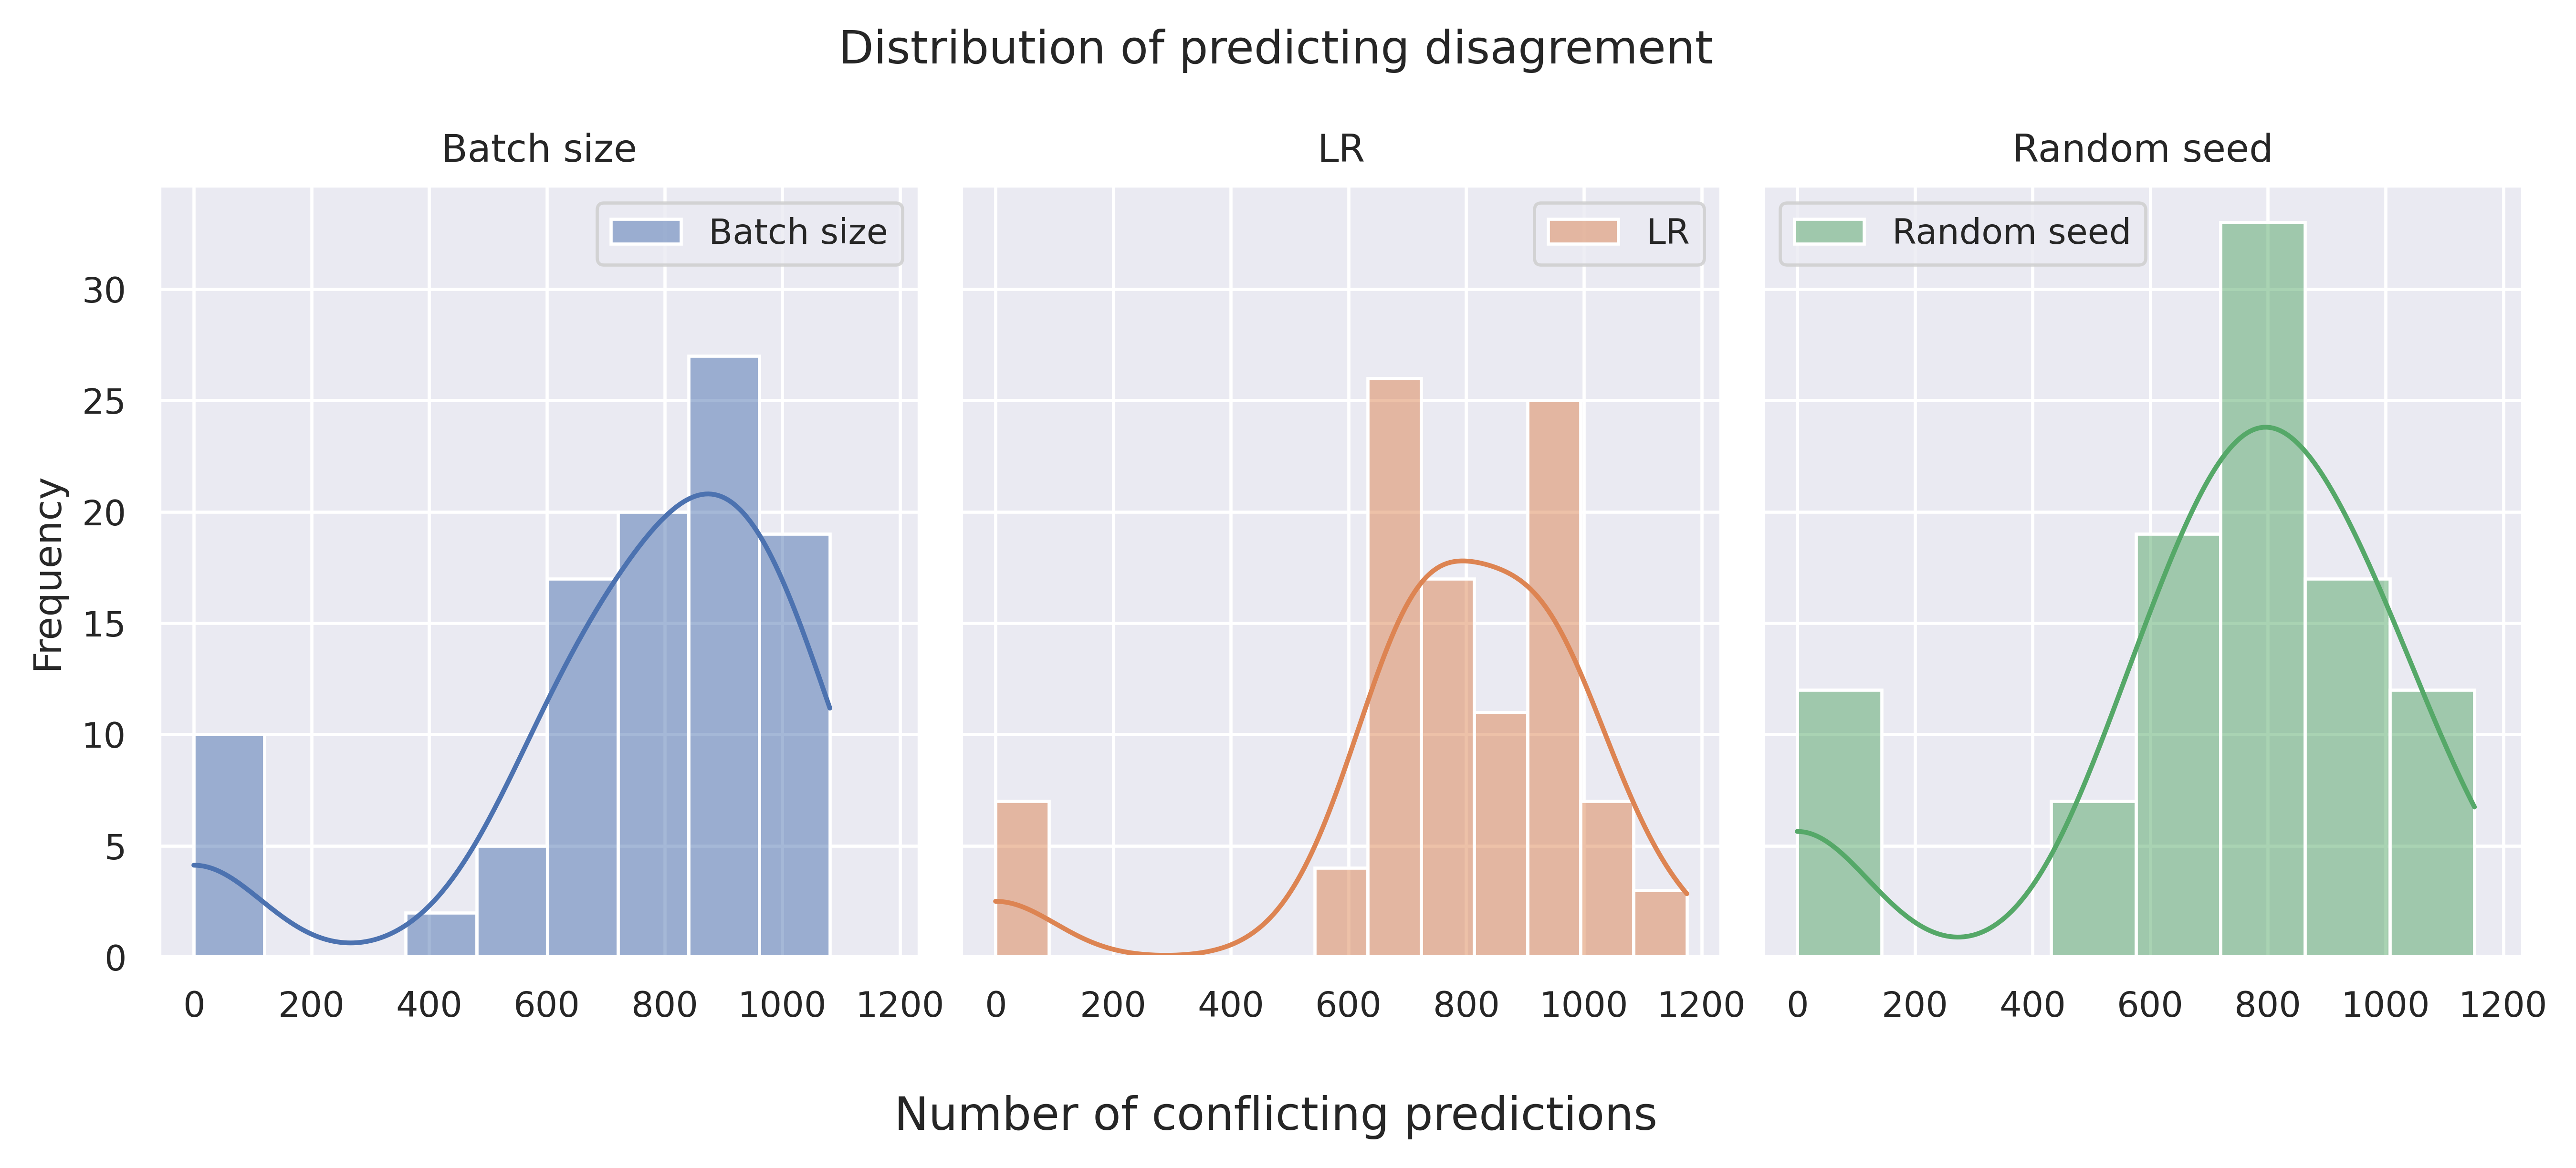

In [26]:
colors = sns.color_palette("deep", 3)
data_frames = [df_bs, df_lr, df_rs]
labels = ['Batch size', 'LR', 'Random seed']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4), sharex=True, sharey=True, dpi=600)
sns.set()
sns.set_context("paper")
fig.suptitle('Distribution of predicting disagrement')
fig.supxlabel('Number of conflicting predictions')
for i, (data, label, color) in enumerate(zip(data_frames, labels, colors)):
    sns.histplot(data=data, x='Disagreement', label=label, kde=True, ax=axes[i], color=color)
    axes[i].set_title(f'{label}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('')
    axes[i].legend()
plt.tight_layout()
plt.show()

### Feature Importance

In [27]:
bs_imp_path = f"/exploiting_model_multiplicity/experiment_results/{dataset_name}/{batches_expmt}/importances.csv"
lr_imp_path = f"/exploiting_model_multiplicity/experiment_results/{dataset_name}/{lr_expmt}/importances.csv"
rs_imp_path = f"/exploiting_model_multiplicity/experiment_results/{dataset_name}/{rs_expmt}/importances.csv"
bs_importance = pd.read_csv(bs_imp_path, index_col="Unnamed: 0")
lr_importance = pd.read_csv(lr_imp_path, index_col="Unnamed: 0")
rs_importance = pd.read_csv(rs_imp_path, index_col="Unnamed: 0")

In [28]:
bs_importance = bs_importance.round(5)
lr_importance = lr_importance.round(5)
rs_importance = rs_importance.round(5)

In [29]:
bs_importance['min'] = bs_importance.apply(lambda row: row.min(), axis=1)
bs_importance['max'] = bs_importance.apply(lambda row: row.max(), axis=1)
bs_importance['avg'] = bs_importance.apply(lambda row: row.mean(), axis=1)
bs_importance['std_dev'] = bs_importance.apply(lambda row: row.std(), axis=1)
bs_importance['avg_abs'] = abs(bs_importance['avg'])

lr_importance['min'] = lr_importance.apply(lambda row: row.min(), axis=1)
lr_importance['max'] = lr_importance.apply(lambda row: row.max(), axis=1)
lr_importance['avg'] = lr_importance.apply(lambda row: row.mean(), axis=1)
lr_importance['std_dev'] = lr_importance.apply(lambda row: row.std(), axis=1)
lr_importance['avg_abs'] = abs(lr_importance['avg'])

rs_importance['min'] = rs_importance.apply(lambda row: row.min(), axis=1)
rs_importance['max'] = rs_importance.apply(lambda row: row.max(), axis=1)
rs_importance['avg'] = rs_importance.apply(lambda row: row.mean(), axis=1)
rs_importance['std_dev'] = rs_importance.apply(lambda row: row.std(), axis=1)
rs_importance['avg_abs'] = abs(rs_importance['avg'])

In [30]:
bs_importance = bs_importance.sort_values(by='avg_abs', ascending=False)
lr_importance = lr_importance.sort_values(by='avg_abs', ascending=False)
rs_importance = rs_importance.sort_values(by='avg_abs', ascending=False)

In [31]:
bs_importance_filt = bs_importance.nlargest(10, 'avg_abs')
lr_importance_filt = lr_importance.nlargest(10, 'avg_abs')
rs_importance_filt = rs_importance.nlargest(10, 'avg_abs')

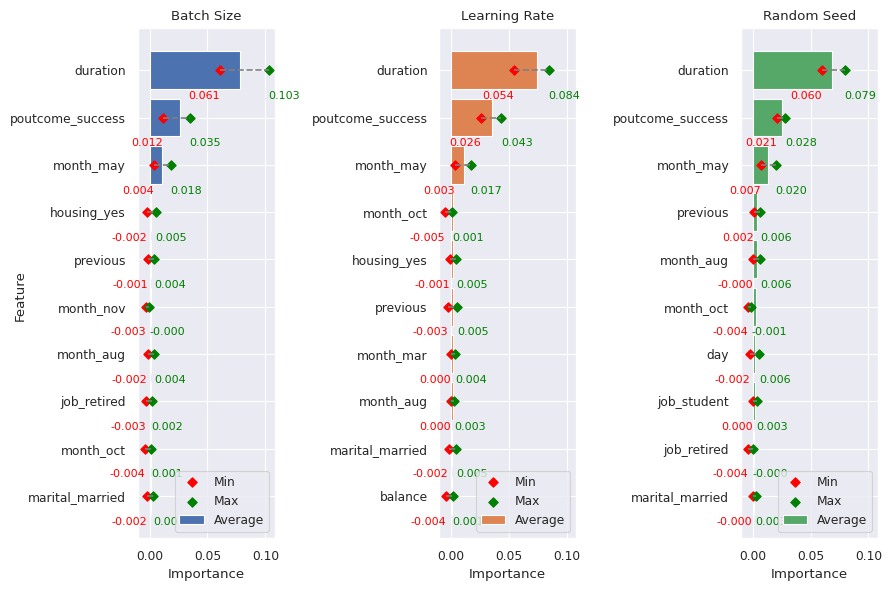

In [33]:
colors = sns.color_palette("deep", 3)

dataframes = [bs_importance_filt, lr_importance_filt, rs_importance_filt]
labels = ['Batch Size', 'Learning Rate', 'Random Seed']
fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharex=True,sharey=False)

sns.set()
sns.set_context("paper")
for i, (df, label, color) in enumerate(zip(dataframes, labels, colors)):
    ax = axes[i]
    ax.barh(df.index, df['avg_abs'], color=color, label='Average')
    ax.scatter(df['min'], df.index, color='red', label='Min', marker='D')
    ax.scatter(df['max'], df.index, color='green', label='Max', marker='D')
    for index, (_, row) in enumerate(df.iterrows()):
        ax.plot([row['min'], row['max']], [index, index], color='grey', linestyle='--')
        offset = 0.54
        ax.text(row['min'], index + offset, f"{row['min']:.3f}", va='center', ha='right', color='red', fontsize=8)
        ax.text(row['max'], index + offset, f"{row['max']:.3f}", va='center', ha='left', color='green', fontsize=8)
    ax.set_xlabel('Importance')
    ax.set_title(f'{label}')
    ax.invert_yaxis()
    ax.legend()
fig.text(0.02, 0.5, 'Feature', va='center', rotation='vertical')

plt.tight_layout()
plt.show()
